Dataset taken from [here](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset)

In [1]:
%matplotlib inline
import cv2, os, h5py, time, telegram_send
from tensorflow.keras import layers, optimizers, regularizers, callbacks, Model, Input
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image as pil_image
import pandas as pd
import numpy as np
from tqdm import tqdm
plt.style.use('seaborn-white')

In [2]:
path1 = '../../datasets/rona/data/Chest_xray_Corona_dataset_Summary.csv'
path2 = '../../datasets/rona/data/Chest_xray_Corona_Metadata.csv'
summary = pd.read_csv(path1)
metadata = pd.read_csv(path2)
summary.head()

Unnamed: 0     Label Label_1_Virus_category Label_2_Virus_category  \
0           0    Normal                    NaN                    NaN   
1           1  Pnemonia         Stress-Smoking                   ARDS   
2           2  Pnemonia                  Virus                    NaN   
3           3  Pnemonia                  Virus               COVID-19   
4           4  Pnemonia                  Virus                   SARS   

   Image_Count  
0         1576  
1            2  
2         1493  
3           58  
4            4

In [3]:
metadata.head()

Unnamed: 0   X_ray_image_name   Label Dataset_type Label_2_Virus_category  \
0           0  IM-0128-0001.jpeg  Normal        TRAIN                    NaN   
1           1  IM-0127-0001.jpeg  Normal        TRAIN                    NaN   
2           2  IM-0125-0001.jpeg  Normal        TRAIN                    NaN   
3           3  IM-0122-0001.jpeg  Normal        TRAIN                    NaN   
4           4  IM-0119-0001.jpeg  Normal        TRAIN                    NaN   

  Label_1_Virus_category  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

In [4]:
summary.shape, metadata.shape

((7, 5), (5910, 6))

In [5]:
%%time
paths = \
[['../../datasets/rona/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/test',
'../../datasets/rona/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/cleaned_test'],
['../../datasets/rona/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train',
'../../datasets/rona/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/cleaned_train']]
for root_dir, save_path in paths:
    os.makedirs(save_path, exist_ok=True)
    count = 0
    for filename in tqdm(os.listdir(root_dir)):
        image = cv2.imread(os.path.join(root_dir, filename))
        mask = metadata.X_ray_image_name==filename
        try:
            label = metadata[mask]['Label'].values[0]
        except IndexError:
            continue
        label_1 = metadata[mask]['Label_1_Virus_category'].values[0]
        label_2 = metadata[mask]['Label_2_Virus_category'].values[0]
        if label == 'Normal':
            folder_path = os.path.join(save_path, label)
            os.makedirs(folder_path, exist_ok=True)
            cv2.imwrite(os.path.join(folder_path, f'{count}.jpg'), image)
        elif label_2 == 'COVID-19':
            folder_path = os.path.join(save_path, label_2)
            os.makedirs(folder_path, exist_ok=True)
            cv2.imwrite(os.path.join(folder_path, f'{count}.jpg'), image)
        else:
            folder_path = os.path.join(save_path, 'Virus')
            os.makedirs(folder_path, exist_ok=True)
            cv2.imwrite(os.path.join(folder_path, f'{count}.jpg'), image)
        count += 1

100%|██████████████████████████████████████████████████████████████████████████████| 5309/5309 [03:10<00:00, 27.84it/s]

Wall time: 3min 39s


Prepare generators and callbacks

Found 4230 images belonging to 3 classes.
Found 1056 images belonging to 3 classes.


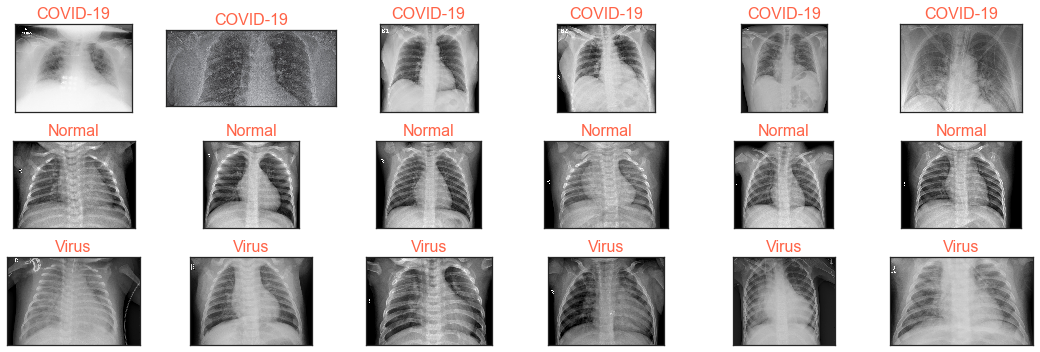

In [6]:
train_dataset_path = \
"../../datasets/rona/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/cleaned_train"
img_size = 224
batch_size = 64
categories = os.listdir(train_dataset_path)
num_classes = len(categories)
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                validation_split=.2)
train_generator = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(img_size, img_size),
        color_mode='rgb',
        batch_size=batch_size,
        shuffle=True,
        seed=0,
        class_mode="categorical",
        subset='training')
test_generator = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(img_size, img_size),
        color_mode='rgb',
        batch_size=batch_size,
        shuffle=True,
        seed=0,
        class_mode="categorical",
        subset='validation')
f, axes = plt.subplots(3, 6, figsize = (15, 5))
for i, category in enumerate(categories):
    path = train_dataset_path + '/' + category
    images = os.listdir(path)
    for j in range(6):
        image = cv2.imread(path + '/' + images[j])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(image)
        axes[i, j].set(xticks=[], yticks=[])
        axes[i, j].set_title(category, color = 'tomato').set_size(16)
plt.tight_layout()
callback_is_nan = callbacks.TerminateOnNaN()
callback_early = callbacks.EarlyStopping(monitor='val_loss', min_delta = 1e-4, patience = 5)
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
plot_losses = PlotLosses()
step_size_train= int(train_generator.n // train_generator.batch_size * 1.5)
step_size_valid= int(test_generator.n // test_generator.batch_size * 1.5)

In [7]:
temp, class_weight, index = {}, {}, 0
for folder in os.listdir(train_dataset_path):
    temp[index] = len(os.listdir(os.path.join(train_dataset_path, folder))); index += 1
index = 0
for value in temp.values():
    class_weight[index] = value / np.min(list(temp.values())); index += 1
class_weight

{0: 1.0, 1: 23.137931034482758, 2: 67.0}

In [8]:
def plot_accuracy(fig_path, history):
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    print('Training Accuracy: {:.3f}'.format(np.max(acc)))
    print('Training Loss: {:.3f}'.format(np.max(loss)))
    print('Validation Accuracy: {:.3f}'.format(np.max(val_acc)))
    print('Validation Loss: {:.3f}'.format(np.max(val_loss)))
    axes[0].plot(acc, label='Train')
    axes[0].plot(val_acc, label='Test')
    axes[0].set_title('Model accuracy')
    axes[0].set(ylabel = 'Accuracy', xlabel = 'Epoch')
    axes[0].legend()
    axes[1].plot(loss, label='Train')
    axes[1].plot(val_loss, label='Test')
    axes[1].set_title('Model loss')
    axes[1].set(ylabel = 'Loss', xlabel = 'Epoch')
    axes[1].legend()
    plt.show()
    f.savefig(f'{fig_path}')
    print('Saved figure at', f'{fig_path}')

In [9]:
def notify(message = ['Done!']):
    if not isinstance(message, list):
        message = [str(message)]
    telegram_send.send(messages = message)

Use VGG16 as feature extractor

In [10]:
K.clear_session()
extractor = VGG16(input_shape = (img_size, img_size, 3), include_top=True,weights ='imagenet')
output = extractor.layers[-5].output
output = layers.GlobalAveragePooling2D()(output)
extractor = Model(extractor.inputs, output)
# extractor.summary()

Helper function to save extracted features for faster optimization of model

In [11]:
def extract_and_save(model, generator, save_path, folder):
    '''model: Model used to extract encoded features
       generator: yields (x_batch, y_batch)
    '''
    save_path = os.path.join(f'../../latent_vectors/{folder}', save_path)
    os.makedirs(save_path, exist_ok=True)
    template = 'batch_{}.h5'
    batch = 0
    for x_batch, y_batch in tqdm(generator):
        clear_output(wait=True)
        features = model.predict(x_batch)
        file_path = os.path.join(save_path, template.format(batch))
        with h5py.File(file_path, 'w') as file:
            # encoded features and hard labels
            file.create_dataset('features', data=features)
            file.create_dataset('labels', data=y_batch)
        batch += 1
        if save_path == 'train':
            if batch >= step_size_train:
                break
        else:
            if batch >= step_size_valid:
                break

Extract and save latent vector from VGG16

In [12]:
%%time
extract_and_save(extractor, train_generator, 'train', 'rona')
extract_and_save(extractor, test_generator, 'test', 'rona')

Wall time: 1min 12s


Data Generator

In [13]:
def load_data(path):
    '''yields (x_batch, y_batch) for model.fit()
    '''
    root_path = os.path.join('../../latent_vectors/', path)
    while True:
        for file_path in os.listdir(root_path):
            with h5py.File(os.path.join(root_path, file_path), 'r') as file:
                yield (np.array(file['features']), np.array(file['labels']))

In [14]:
def train(lr,
          optimizer = None,
          train_path = None,
          dropout = None,
          input_shape = None,
          test_path = None,
          notification = True,
          dataset = None,
          epochs = 2,
          folder = None,
          fig_path = None,
          model_path = None):
    '''
       Helper function to add Dense layer and handle temperature of softmax to the input.
       Input is extracted latent vector from a pretrained model
       
       input_shape: shape of the input from GlobalAveragePooling2D layer
    '''
    K.clear_session()
    # shape of VGG16 encoded features
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(optimizer=optimizer(lr=lr, decay=lr/epochs),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
              x = load_data(os.path.join(dataset, train_path)),
              epochs=epochs,
              workers=15,
              class_weight=class_weight,
              steps_per_epoch = step_size_train,
              validation_data = load_data(os.path.join(dataset, test_path)),
              validation_steps = step_size_valid,
              callbacks=[plot_losses, callback_is_nan, callback_early])
    root_dir = f'../../results/figures/{dataset}'
    root_dir = os.path.join(root_dir, folder)
    os.makedirs(root_dir, exist_ok=True)
    plot_accuracy(os.path.join(root_dir, fig_path), history)
    root_dir = f'../../results/models/{dataset}'
    root_dir = os.path.join(root_dir, folder)
    os.makedirs(root_dir, exist_ok=True)
    model.save(os.path.join(root_dir, model_path))
    if notification: notify()
    return model, history

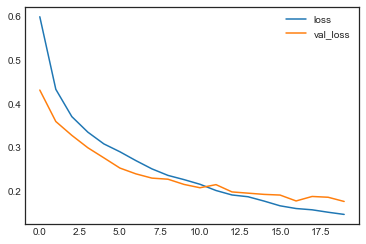

99/99 [==============================] - 2s 23ms/step - loss: 0.1466 - accuracy: 0.9495 - val_loss: 0.1762 - val_accuracy: 0.9395
Training Accuracy: 0.949
Training Loss: 0.599
Validation Accuracy: 0.939
Validation Loss: 0.431


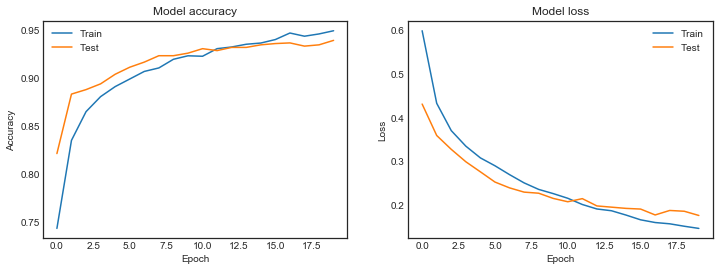

Saved figure at ../../results/figures/rona\transfer_learning\model.png
Wall time: 33.7 s


In [15]:
%%time
with tf.device("GPU:0"):
    model, _ = train(input_shape = (512),
                     dropout=.5,
                     train_path = 'train',
                     test_path = 'test',
                     lr = 5e-4,
                     epochs = 20,
                     optimizer = optimizers.Adam,
                     dataset = 'rona',
                     folder = 'transfer_learning',
                     fig_path = f'model.png',
                     model_path = f'model.h5')
# model.summary()

Elucidated from [here](https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md)

In [16]:
def visualize(model, image):
    model_layers = model.layers
    # Extracts the outputs
    layer_outputs = [layer.output for layer in model.layers]
    # Creates a model that will return these outputs, given the model input
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    # get activations
    activations = activation_model.predict(image)
    images_per_row = 4; count = -1
    # Displays the feature maps
    for layer, layer_activation in zip(model_layers, activations):
        if not isinstance(layer, layers.Conv2D):
            continue
        count += 1
        # show first 3 conv layers
        if count == 3:
            break
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Post-processes the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std() + 1e-8
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 2 / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer.name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
    return [layer.name for layer in model.layers if isinstance(layer, layers.Conv2D)]

In [17]:
images, labels = test_generator.next()

In [18]:
extractor = VGG16(input_shape = (img_size, img_size, 3), include_top=True,weights ='imagenet')
output = extractor.layers[-5].output
output = layers.GlobalAveragePooling2D()(output)
extractor = Model(extractor.inputs, output)

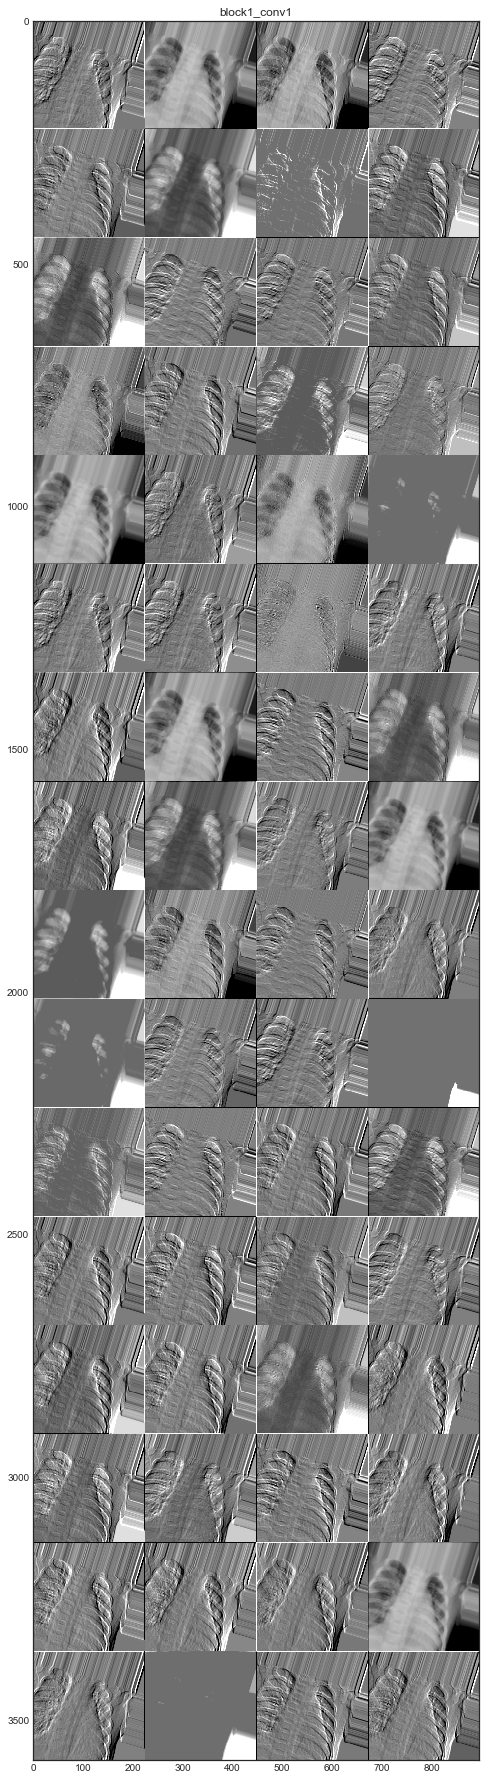

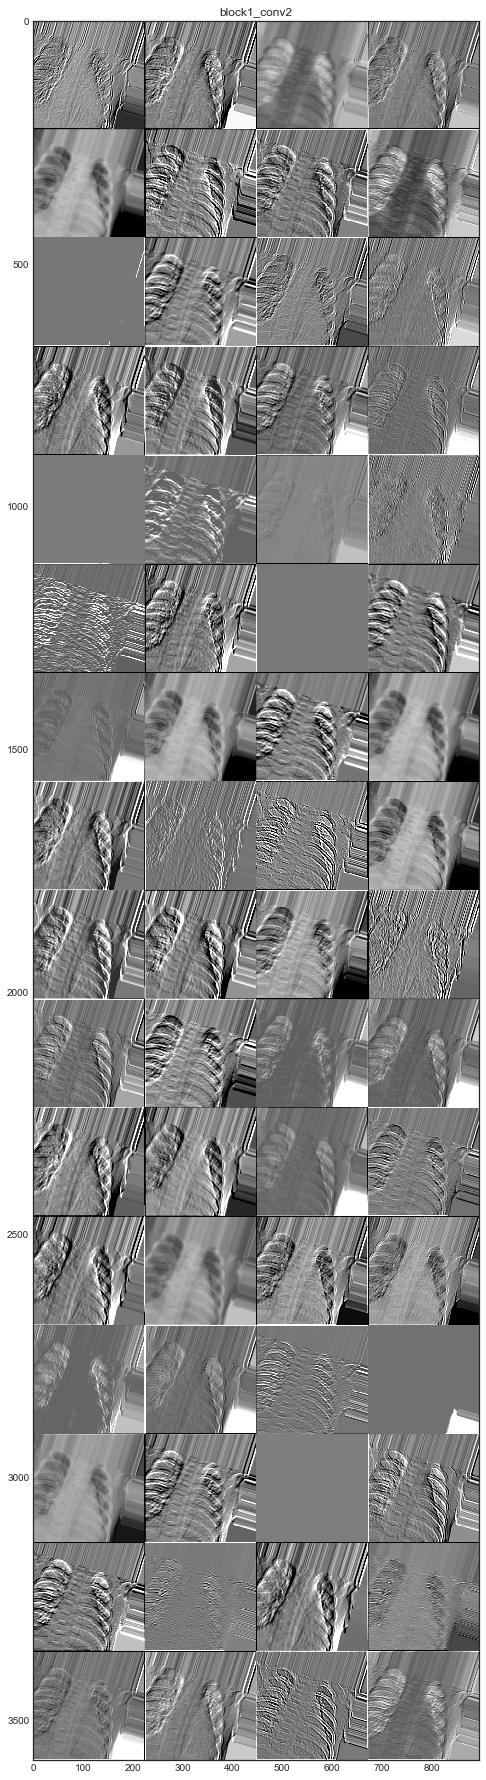

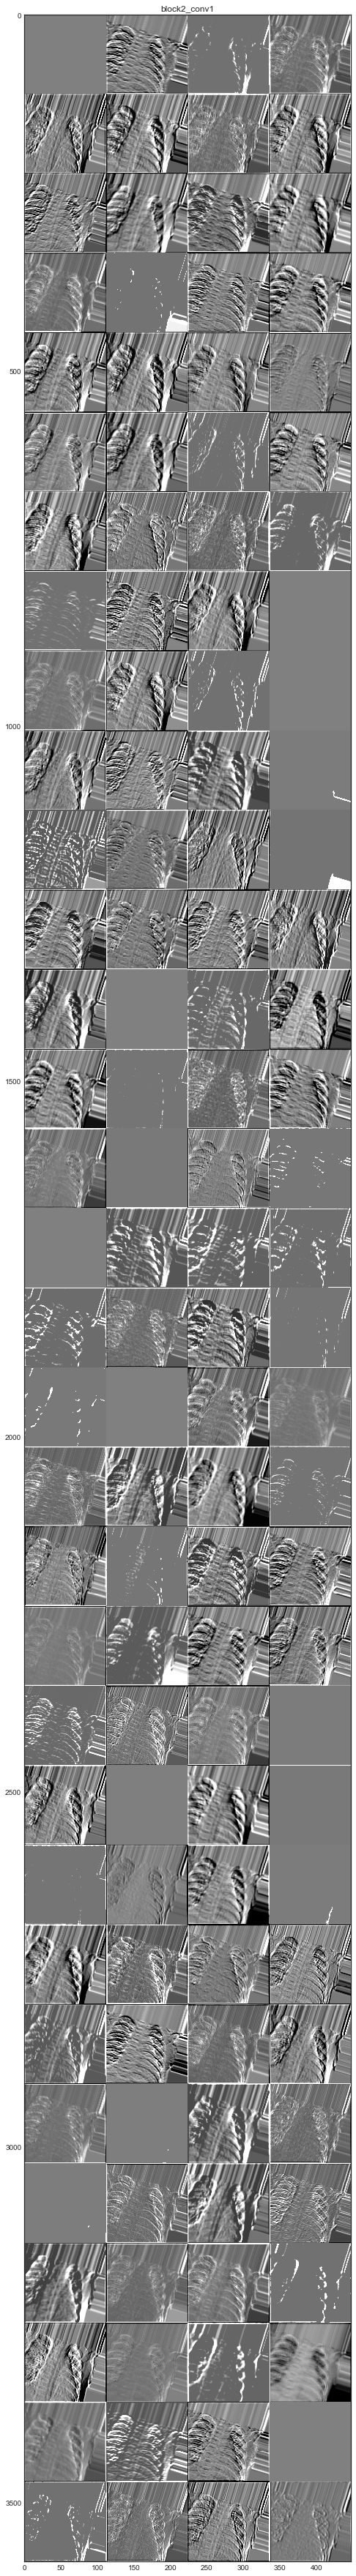

In [19]:
index = 10
image = images[index:index+1]
names = visualize(extractor, image)

Elucidated from [here](https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/)

In [20]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs[0]],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        # guidedGrads = guidedGrads[0]
        guidedGrads = grads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = ((1 - heatmap) * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap
    def overlay_heatmap(self, heatmap, image, alpha=0.2, colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap).reshape(1, img_size, img_size, 3)
        output = image*255*(1-alpha) + heatmap.reshape(1, img_size, img_size, 3)*alpha
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        output = np.uint8(output)
        return (heatmap, output)

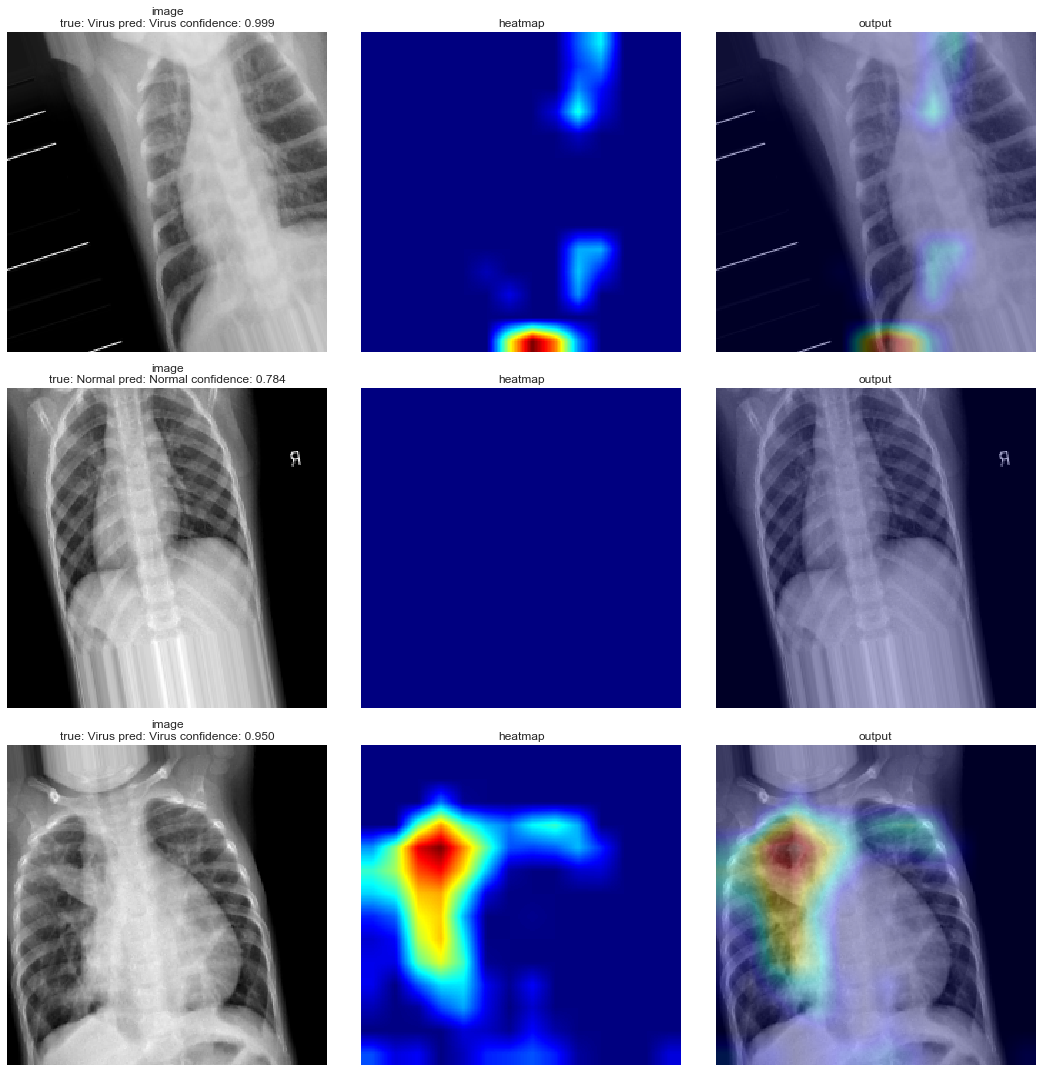

In [21]:
f, axes = plt.subplots(3, 3, figsize=(15, 15))
count = 0
for i in range(9):
    image = images[i//3+count:i//3+1+count]
    preds = model(extractor(image))
    index = np.argmax(preds[0])
    # initialize our gradient class activation map and build the heatmap
    cam = GradCAM(extractor, index, names[-1])
    heatmap = cam.compute_heatmap(image)
    (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.3)
    description = 'image\ntrue: {} pred: {} confidence: {:.3f}'.format\
    (categories[np.argmax(labels[i//3+count])], categories[index], preds[0][index])
    
    axes[i//3, 0].imshow(image.reshape(img_size, img_size, 3))
    axes[i//3, 1].imshow(heatmap.reshape(img_size, img_size, 3))
    axes[i//3, 2].imshow(output.reshape(img_size, img_size, 3))
    axes[i//3, 0].set_title(description).set_size(12)
    axes[i//3, 1].set_title('heatmap')
    axes[i//3, 2].set_title('output')
    axes[i//3, i%3].axis('off')
plt.tight_layout()

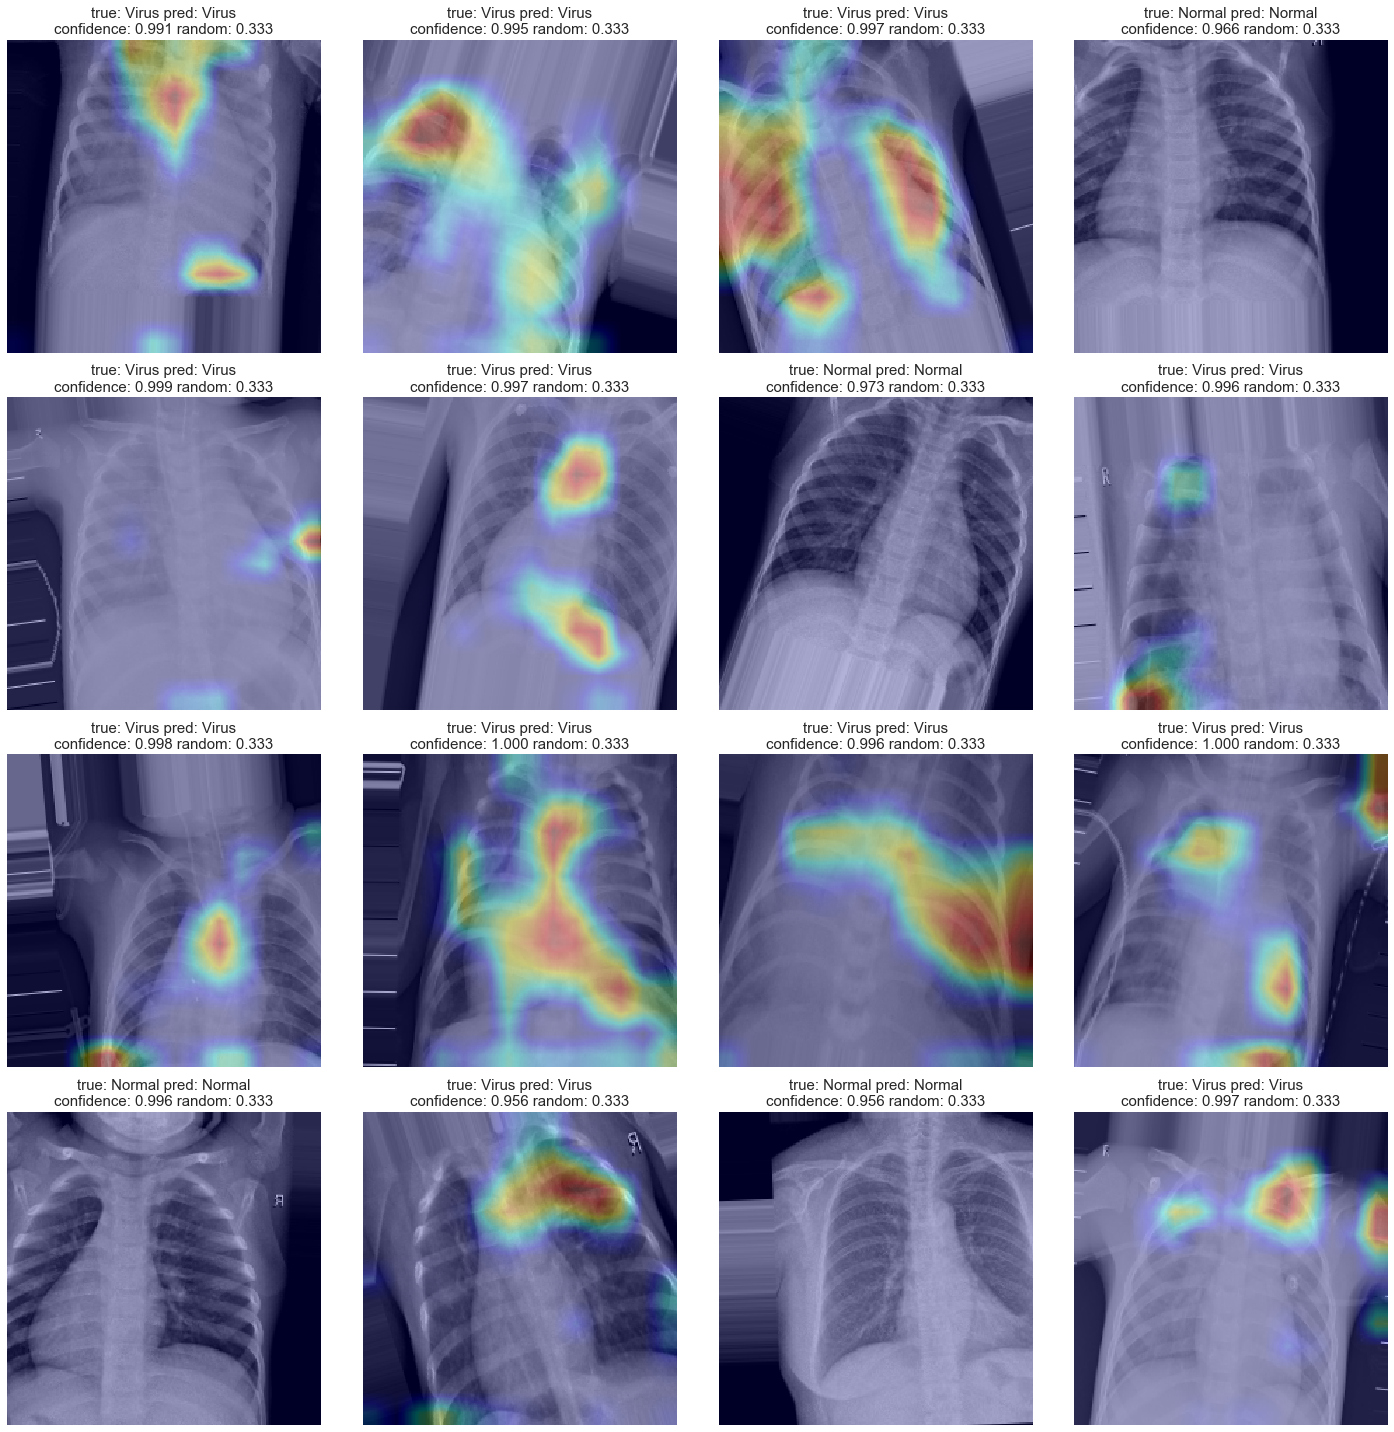

In [22]:
f, axes = plt.subplots(4, 4, figsize=(20, 20))
count = 9
for i in range(16):
    image = images[i+count:i+1+count]
    preds = model(extractor(image))
    index = np.argmax(preds[0])
    # initialize our gradient class activation map and build the heatmap
    cam = GradCAM(extractor, index, names[-1])
    heatmap = cam.compute_heatmap(image)
    (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.3)
    description = 'true: {} pred: {}\nconfidence: {:.3f} random: {:.3f}'.format\
    (categories[np.argmax(labels[i+count])], categories[index], preds[0][index], 1/len(categories))
    
    axes[i//4, i%4].imshow(output.reshape(img_size, img_size, 3))
    axes[i//4, i%4].set_title(description).set_size(15)
    axes[i//4, i%4].axis('off')
plt.tight_layout()